In [54]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch

LABELS = 5
TRAIN_EPOCHS = 5
VAL_SPLIT = 0.1
MAX_TOKENS = 32
BATCH_SIZE = 128

base_path = '/kaggle/input/nitro-language-processing-2'
train_df = pd.read_csv(f'{base_path}/train_data.csv')
test_df = pd.read_csv(f'{base_path}/test_data.csv')

In [55]:
from transformers import MT5EncoderModel, T5Tokenizer, AutoConfig
from torch import cuda

device = 'cuda' if cuda.is_available() else 'cpu'
tokenizer = T5Tokenizer.from_pretrained("google/mt5-small")

In [56]:
!pip install pytictoc
from pytictoc import TicToc

In [57]:
t = TicToc()
t.tic()
tokenized_sentences = tokenizer(train_df['Text'].tolist(), return_tensors="pt", padding=True, truncation=True, max_length=MAX_TOKENS)
t.toc()

Elapsed time is 9.677573 seconds.


In [58]:
tokenized_sentences['input_ids'][0]

tensor([  1250,    424, 137562,  38423,  11775,   2150,   6510,   4560,    703,
           480,   2331,    728,    259,  54182,    270,   4767,    302,  34687,
           260,  90635,  90635,    260,    260,   1464,  66114,    259,  73486,
          4394,    259,  72329, 239199,      1])

In [59]:
mt5_default = MT5EncoderModel.from_pretrained("google/mt5-small")

Some weights of the model checkpoint at google/mt5-small were not used when initializing MT5EncoderModel: ['decoder.block.4.layer.2.layer_norm.weight', 'decoder.block.2.layer.0.SelfAttention.q.weight', 'decoder.block.2.layer.0.SelfAttention.o.weight', 'decoder.block.1.layer.2.DenseReluDense.wo.weight', 'decoder.block.5.layer.1.EncDecAttention.v.weight', 'decoder.block.7.layer.0.SelfAttention.o.weight', 'decoder.block.6.layer.1.EncDecAttention.k.weight', 'decoder.block.6.layer.1.EncDecAttention.v.weight', 'decoder.block.0.layer.2.DenseReluDense.wo.weight', 'decoder.block.5.layer.1.EncDecAttention.q.weight', 'decoder.block.1.layer.1.EncDecAttention.k.weight', 'decoder.block.7.layer.2.DenseReluDense.wo.weight', 'decoder.block.6.layer.2.DenseReluDense.wo.weight', 'decoder.block.4.layer.0.SelfAttention.q.weight', 'decoder.block.5.layer.1.EncDecAttention.k.weight', 'decoder.block.0.layer.0.layer_norm.weight', 'decoder.block.1.layer.0.SelfAttention.o.weight', 'decoder.block.7.layer.2.DenseRel

In [60]:
label_to_int = {
            'direct': 0,
            'descriptive': 1,
            'reporting': 2,
            'non-offensive': 3,
            'offensive': 4,
}

train_df['labels'] = train_df['Final Labels'].map(label_to_int)
labels_encoded = train_df['labels'].to_numpy()

In [61]:
class MT5Dataset(torch.utils.data.Dataset):
    def __init__(self, tokenized, labels = None):
        self.tokenized = tokenized
        self.labels = labels
    
    def __getitem__(self, index):
        item = {
            'input_ids': self.tokenized['input_ids'][index],
            'attention_mask': self.tokenized['attention_mask'][index],
        }
        if self.labels is not None:
            item['labels'] = self.labels[index]
        return item

    def __len__(self):
        return len(self.tokenized['input_ids'])

class MyMT5(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.mt5 = mt5_default
        self.fc_head = torch.nn.Linear(MAX_TOKENS * 512, LABELS)
    def forward(self, input_ids, attention_mask):
        y = self.mt5(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        y = y.view(y.shape[0], -1)
        y = self.fc_head(y)
        return y
    
model = MyMT5()

In [62]:
from sklearn.model_selection import train_test_split

X_train_ids, X_test_ids, y_train, y_test = train_test_split(tokenized_sentences['input_ids'], labels_encoded, test_size=VAL_SPLIT, random_state=42, stratify=labels_encoded)
X_train_attention, X_test_attention, y_train_2, y_test_2 = train_test_split(tokenized_sentences['attention_mask'], labels_encoded, test_size=VAL_SPLIT, random_state=42, stratify=labels_encoded)
assert y_train[67] == y_train_2[67]

In [63]:
!pip install lightning

In [64]:
X_train = {
    'input_ids': X_train_ids,
    'attention_mask': X_train_attention,
}

X_test = {
    'input_ids': X_test_ids,
    'attention_mask': X_test_attention,
}

In [65]:
train_dataset = MT5Dataset(X_train, labels=y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = MT5Dataset(X_test, labels=y_test)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)


In [66]:
import lightning.pytorch as pl
from sklearn.metrics import balanced_accuracy_score

class LightingModule(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def training_step(self, batch, batch_idx):
        y = batch['labels']
        y_hat = self.model(batch['input_ids'], batch['attention_mask'])
        
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        y = batch['labels']
        y_hat = self.model(batch['input_ids'], batch['attention_mask'])
        
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)
        
        y_hat_class = torch.argmax(y_hat, dim=1).cpu()
        y = y.cpu()
        acc = balanced_accuracy_score(y, y_hat_class)
        
        self.log("val_acc", acc, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        y = batch['labels']
        y_hat = self.model(batch['input_ids'], batch['attention_mask'])
        
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        
        y_hat_class = torch.argmax(y_hat, dim=1).cpu()
        y = y.cpu()
        acc = balanced_accuracy_score(y, y_hat_class)
        
        self.log("test_loss", loss)
        self.log("test_acc", acc)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [67]:
mymodule = LightingModule(model)
trainer = pl.Trainer(max_epochs=TRAIN_EPOCHS, accelerator="gpu")
trainer.fit(mymodule, train_loader, val_loader)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type  | Params
--------------------------------
0 | model | MyMT5 | 147 M 
--------------------------------
147 M     Trainable params
0         Non-trainable params
147 M     Total params
588.090   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
INFO: `Trainer.fit` stopped: `max_epochs=1` reached.


In [68]:
trainer.logged_metrics

{'train_loss': tensor(0.4699),
 'val_loss': tensor(0.4610),
 'val_acc': tensor(0.5341, dtype=torch.float64)}

In [69]:
trainer.test(mymodule, dataloaders=val_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5341048716961524     │
│         test_loss         │    0.4609927833080292     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4609927833080292, 'test_acc': 0.5341048716961524}]

In [70]:
test_tokenized_sentences = tokenizer(test_df['Text'].tolist(), return_tensors="pt", padding=True, truncation=True, max_length=MAX_TOKENS)

test_dataset = MT5Dataset(test_tokenized_sentences)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [71]:
mymodule.model.eval()
mymodule.model.to(device)
predictions = []
for batch in test_loader:
    y_hat = mymodule.model(batch['input_ids'].to(device), batch['attention_mask'].to(device))        
    y_hat_class = torch.argmax(y_hat, dim=1).cpu()
    predictions.append(y_hat_class)

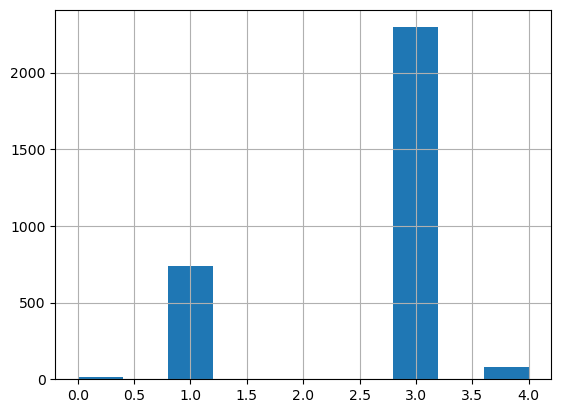

In [72]:
results = []
for p in predictions:
    results.extend(p.tolist())
sample = pd.read_csv(f'{base_path}/sample_submission.csv')
sample['Label'] =  results
sample['Label'].hist()

sample.to_csv('submission.csv', index=False)